In [ ]:
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv

pd.set_option("display.max_columns", None)

from shipping_cost_analysis.etl import db_tools, file_io, preprocessing
from shipping_cost_analysis.models.schema import (    
    Customer,
    Product,
    Region,
    Transactions,
)
from shipping_cost_analysis.models.state_mapping import us_state_codes, us_states

load_dotenv(override=True)

modules_to_reload = [file_io, preprocessing, db_tools]
for module in modules_to_reload:
    importlib.reload(module)

In [55]:
# import data

file_names = [
    "dim_customers",
    "dim_products",
    "fact_sales_modified",
    "state_region_mapping",
]
dataframes = {}

for file_name in file_names:
    try:
        df = file_io.read_or_write_csv(
            file_name + ".csv",
            file_dir="data",
            to_read=True,
            file_encoding="ISO-8859-1",
            file_sep=",",
        )
        dataframes[file_name] = df
    except FileNotFoundError as e:
        print(f"Error loading {file_name}: {e}")

### **Preprocessing**

In [56]:
# check percent share missing values per column

for file in dataframes:
    missing_data = preprocessing.missing_data(dataframes[file])
    if missing_data.shape[0]:
        print(f"{file}:\n {missing_data}\n")

dim_customers:
            Total  Percentage Missing
Latitude      98                2.24
Longitude     98                2.24

fact_sales_modified:
                   Total  Percentage Missing
Customer ID        5434               21.29
Invoice No         1889                7.40
Unit Price         1292                5.06
Quantity           1283                5.03
Sales              1281                5.02
Description        1245                4.88
Stock Code         1225                4.80
Transaction Date   1224                4.79



In [57]:
for file in dataframes:
    print(file)
    display(dataframes[file].head(3))

dim_customers


,Customer ID,Order City,Order Postal,Order State,Latitude,Longitude
0,18287,Rock Springs,82901-7321,WY,41.5869,-109.2048
1,18283,JACKSON,83001-9460,WY,43.4800,-110.7618
2,18282,Greybull,82426,WY,44.4892,-108.0562


dim_products


,Stock Code,Weight,Landed Cost,Shipping_Cost_1000_mile,Description,Category
0,22423,40.0,35.0,20.0,Taste of the Wild High Prairie Grain-Free Dry ...,Food
1,85123A,2.0,6.0,5.0,Dog and Puppy Pads,Disposables
2,47566,6.0,18.0,12.0,"Memory Foam Pet Beds for Small, Medium, and La...",Disposables


fact_sales_modified


,Transaction Date,Customer ID,Description,Stock Code,Invoice No,Quantity,Sales,Unit Price
0,12/1/2020 8:26,17850.0,Dog and Puppy Pads,85123A,536365.0,1.0,15.30,15.30
1,12/1/2020 8:34,13047.0,Pet Odor Eliminator,84879,536367.0,6.0,60.84,10.14
2,12/1/2020 8:34,13047.0,Rechargeable Pet Nail Grinder,22960,536368.0,1.0,25.50,NaN


state_region_mapping


,ï»¿Order State,State,Region
0,AE,AE,Other
1,ak,AK,Other
2,AK,AK,Other


In [58]:
# split into data frames

customer = dataframes[file_names[0]]
product = dataframes[file_names[1]]
transactions = dataframes[file_names[2]]
region = dataframes[file_names[3]]

In [59]:
# rename columns

customer = customer.rename(
    columns={
        "Customer ID": "customer_id",
        "Order City": "order_city",
        "Order Postal": "order_postal",
        "Order State": "order_state",
        "Latitude": "latitude",
        "Longitude": "longitude",
    }
)

product = product.rename(
    columns={
        "Stock Code": "stock_code",
        "Weight": "weight",
        "Landed Cost": "landed_cost",
        "Shipping_Cost_1000_mile": "shipping_cost_1000_r",
        "Description": "description",
        "Category": "category",
    }
)

transactions = transactions.rename(
    columns={
        "Transaction Date": "transaction_date",
        "Customer ID": "customer_id",
        "Description": "description",
        "Stock Code": "stock_code",
        "Invoice No": "invoice_no",
        "Quantity": "quantity",
        "Sales": "sales",
        "Unit Price": "unit_price",
    }
)

region = region.rename(
    columns={"ï»¿Order State": "order_state", "State": "state", "Region": "region"}
)

### cleaning US state codes in customer table
**cleaning order state codes & state names in customer and region tables**

In [60]:
# cleaning

customer["order_city"] = customer["order_city"].str.title()
customer["order_postal"] = customer["order_postal"].str.split("-").str[0]
customer["order_state"] = (
    customer["order_state"].str.upper().str.replace(".", "").str.strip()
)

In [61]:
# mapping us states


def normalize_state(val):
    valid_state_codes = set(us_states.values())
    if not isinstance(val, str):
        return None
    val = val.strip().upper()
    if val in valid_state_codes:
        return val  # already a valid code
    return us_states.get(val, None)  # map from name


customer["order_state"] = customer["order_state"].apply(normalize_state)

In [62]:
# states which are not valid

customer[(customer["order_state"].str.len() > 2) | (customer["order_state"].isnull())]

,customer_id,order_city,order_postal,order_state,latitude,longitude
405,17727,St.Croix,00851,None,NaN,NaN
835,17138,Mayaguez,00682,None,18.2027,-67.1465
4271,12471,Fpo,09645,None,NaN,NaN
4272,12468,Fpo,09618,None,NaN,NaN
4273,12465,Apo,09021,None,NaN,NaN
4274,12464,Apo,9811,None,NaN,NaN
4275,12463,Apo,9354,None,NaN,NaN
4276,12462,Apo,9330,None,NaN,NaN
4277,12461,Apo,9250,None,NaN,NaN


In [63]:
customer[
    customer["latitude"].isnull()
]  # cannot be cleaned, because for those order_postal no non-missing coordinates

,customer_id,order_city,order_postal,order_state,latitude,longitude
25,18250,Weston,54476,WI,NaN,NaN
80,18179,Hiles,54511,WI,NaN,NaN
91,18167,Eau Galle,54737,WI,NaN,NaN
168,18064,Quil Ceda Village,98271,WA,NaN,NaN
252,17940,Roanoke City,24014,VA,NaN,NaN
...,...,...,...,...,...,...
4276,12462,Apo,9330,None,NaN,NaN
4277,12461,Apo,9250,None,NaN,NaN
4314,12418,N Arlington,07031,NJ,NaN,NaN
4355,12363,Lauderhill,33311,FL,NaN,NaN


### Cleaning region table

In [64]:
# map US state codes to retrieve valid state names

region["order_state"] = region["state"]
region["state"] = region["order_state"].map(us_state_codes)

In [65]:
region["region"].value_counts()

region
East       74
Central    71
West       34
Other      13
Name: count, dtype: int64

In [66]:
# order states not valid

region[(region["order_state"].isnull()) | region["state"].isnull()]

,order_state,state,region
0,AE,NaN,Other
169,VI,NaN,Other


In [67]:
region["state"].unique()

array([nan, 'Alaska', 'Alabama', 'Arkansas', 'Arizona', 'California',
       'Colorado', 'Connecticut', 'District of Columbia', 'Delaware',
       'Florida', 'Georgia', 'Hawaii', 'Iowa', 'Idaho', 'Illinois',
       'Indiana', 'Kansas', 'Kentucky', 'Louisiana', 'Massachusetts',
       'Maine', 'Maryland', 'Michigan', 'Minnesota', 'Missouri',
       'Montana', 'Mississippi', 'North Carolina', 'New York',
       'North Dakota', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Virginia',
       'Vermont', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

### Cleaning quantity & prices in transaction table

**convert data types & remove outlier**

In [68]:
# convert data types

transactions["transaction_date"] = pd.to_datetime(transactions["transaction_date"])

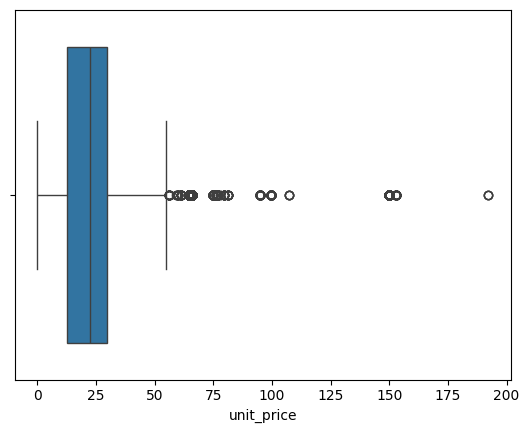

In [69]:
# remove outliers: price error

transactions = transactions[transactions["unit_price"] <= 500]

sns.boxplot(data=transactions, x="unit_price")
plt.show()

**Fix missing stock code + description**  
- fill missing description based on stock code  
- stock code: interpolate missing values by description

In [70]:
# Mapping for missing description: Stock Code → Description
code_to_desc = {
    k: v
    for k, v in transactions.dropna(subset=["stock_code", "description"])
    .drop_duplicates("stock_code")
    .set_index("stock_code")["description"]
    .items()
    if not pd.isna(k)
}
# fill missing description
transactions["description"] = transactions["description"].fillna(
    transactions["stock_code"].map(code_to_desc)
)

In [71]:
desc_to_code = {
    k: v
    for k, v in transactions.dropna(subset=["stock_code", "description"])
    .drop_duplicates("description")
    .set_index("description")["stock_code"]
    .items()
    if not pd.isna(k)
}
# fill missing stock code
transactions["stock_code"] = transactions["stock_code"].fillna(
    transactions["description"].map(desc_to_code)
)

In [72]:
# Exclude 64 transaction with missing stock code + description (no mapping possible)
transactions = transactions[~transactions["stock_code"].isnull()]

**Fix unit price == 0: fill NA values based on stock code**  


In [73]:
transactions[(transactions["quantity"].isnull()) & (transactions["unit_price"] == 0)]

,transaction_date,customer_id,description,stock_code,invoice_no,quantity,sales,unit_price
1554,2020-12-22 14:41:00,NaN,Dog and Puppy Pads,85123A,539856.0,NaN,0.0,0.0
6098,2021-04-08 15:06:00,NaN,ProBiotic Supplements for Dogs,79321,549500.0,NaN,0.0,0.0
7073,NaT,NaN,UltraSound Dog Barking Deterrent,22720,NaN,NaN,NaN,0.0
16512,2021-09-21 16:17:00,NaN,Purina Pro Plan Adult Sensitive Skin,23284,567680.0,NaN,0.0,0.0


In [74]:
# first convert 0 values to NA
transactions["unit_price"] = transactions["unit_price"].apply(
    lambda x: np.nan if x == 0 else x
)

In [75]:
# mapping: only stock code with valid min price
valid_prices = transactions.dropna(subset=["stock_code", "unit_price"])
price_map = valid_prices.groupby("stock_code")["unit_price"].min().to_dict()

# fill missing unit prices
transactions["unit_price"] = transactions["unit_price"].fillna(
    transactions["stock_code"].map(price_map)
)

**Fill missing quantity and sales, where both are na!**

In [76]:
# fill missing quantity + sales (where both are missing!); assumption: min unit_price = 1 quantity


def impute_missing_sales_and_quantity(df, price_map):
    mask = df["quantity"].isna() & df["sales"].isna() & df["stock_code"].notna()
    df.loc[mask, "quantity"] = 1
    df.loc[mask, "sales"] = df.loc[mask, "stock_code"].map(price_map)
    return df

In [77]:
transactions = impute_missing_sales_and_quantity(transactions, price_map=price_map)

**Fill missing quantity based on sales and unit price**

In [78]:
transactions[(transactions["quantity"].isna()) & (~transactions["sales"].isna())]

,transaction_date,customer_id,description,stock_code,invoice_no,quantity,sales,unit_price
7,2020-12-01 09:37:00,14688.0,Milk-Bone MaroSnacks Dog Treats with Real Bone,22386,536378.0,NaN,23.40,11.70
49,2020-12-01 12:31:00,17897.0,Rechargeable Pet Nail Grinder,22960,536488.0,NaN,51.00,25.50
121,NaT,17850.0,Dog and Puppy Pads,85123A,536612.0,NaN,15.30,15.30
122,2020-12-02 10:10:00,17925.0,Canned Cat Food,21137,536616.0,NaN,244.08,20.34
126,2020-12-02 10:53:00,15658.0,Taste of the Wild High Prairie Grain-Free Dry ...,22423,536627.0,NaN,76.50,76.50
...,...,...,...,...,...,...,...,...
25318,2021-05-06 10:00:00,17809.0,Purina Pro Plan Adult Sensitive Skin,23284,552048.0,NaN,283.50,40.50
25380,2021-10-02 13:26:00,16007.0,Pet Hair Remover,23203,569220.0,NaN,12.48,12.48
25404,2021-04-12 13:38:00,16705.0,"Memory Foam Pet Beds for Small, Medium, and La...",47566,NaN,NaN,224.10,24.90
25452,2021-10-04 14:53:00,16242.0,Pet Grooming Brush,20725,569528.0,NaN,19.80,9.90


In [79]:
# fill quantity
mask = (
    transactions["quantity"].isna()
    & transactions["unit_price"].notna()
    & transactions["sales"].notna()
)
transactions.loc[mask, "quantity"] = (
    transactions.loc[mask, "sales"] / transactions.loc[mask, "unit_price"]
)

**set quantity to 1 where 0**

In [80]:
transactions[(transactions["quantity"] == 0) & (transactions["unit_price"] > 0)]

,transaction_date,customer_id,description,stock_code,invoice_no,quantity,sales,unit_price
186,2020-12-02 17:27:00,15384.0,Sheba Perfect Portions Pat Wet Cat Food,22197,NaN,0.0,0.0,5.1
434,2020-12-06 12:55:00,14487.0,Taste of the Wild High Prairie Grain-Free Dry ...,22423,NaN,0.0,0.0,76.5
439,2020-12-06 13:17:00,16550.0,Sheba Perfect Portions Pat Wet Cat Food,22197,NaN,0.0,0.0,5.1
476,2020-12-06 15:12:00,13481.0,Rechargeable Pet Nail Grinder,22960,NaN,0.0,0.0,25.5
527,2020-12-07 12:45:00,17511.0,Dog and Puppy Pads,85123A,NaN,0.0,0.0,15.3
...,...,...,...,...,...,...,...,...
25010,2021-01-14 16:58:00,16235.0,UltraSound Dog Barking Deterrent,22720,NaN,0.0,0.0,29.7
25154,2021-10-04 17:51:00,16401.0,Sheba Perfect Portions Pat Wet Cat Food,22197,NaN,0.0,0.0,5.1
25279,2021-03-31 11:58:00,16801.0,UltraSound Dog Barking Deterrent,22720,NaN,0.0,0.0,29.7
25333,2021-11-18 09:54:00,13266.0,UltraSound Dog Barking Deterrent,22720,NaN,0.0,0.0,29.7


In [81]:
# fix quantity = 0

transactions["quantity"] = transactions["quantity"].apply(lambda x: 1 if x == 0 else x)

**fix negative values**

In [82]:
transactions[(transactions["quantity"] < 0)]

,transaction_date,customer_id,description,stock_code,invoice_no,quantity,sales,unit_price
53,2020-12-01 12:38:00,17897.0,Rechargeable Pet Nail Grinder,22960,NaN,-1.0,-25.5,25.5
662,2020-12-08 13:33:00,14299.0,Taste of the Wild High Prairie Grain-Free Dry ...,22423,NaN,-1.0,-65.7,65.7
773,2020-12-09 14:10:00,NaN,Taste of the Wild High Prairie Grain-Free Dry ...,22423,538072.0,-2.0,0.0,24.0
905,2020-12-10 15:01:00,13798.0,Earth Rated Dog Poop Bags,85099B,NaN,-2.0,-19.8,9.9
1050,2020-12-14 09:54:00,13802.0,Taste of the Wild High Prairie Grain-Free Dry ...,22423,NaN,-1.0,-65.7,65.7
...,...,...,...,...,...,...,...,...
25040,2021-04-04 12:28:00,15223.0,Rechargeable Pet Nail Grinder,22960,NaN,-1.0,NaN,25.5
25079,2021-01-14 14:33:00,14299.0,Taste of the Wild High Prairie Grain-Free Dry ...,22423,NaN,-1.0,-65.7,65.7
25111,2020-12-14 09:54:00,13802.0,Taste of the Wild High Prairie Grain-Free Dry ...,22423,NaN,-1.0,-65.7,65.7
25156,2020-12-20 13:54:00,NaN,Taste of the Wild High Prairie Grain-Free Dry ...,22423,NaN,-2.0,-131.4,65.7


In [83]:
transactions["quantity"] = abs(transactions["quantity"]).astype(int)
transactions["sales"] = abs(transactions["sales"])
transactions["unit_price"] = abs(transactions["unit_price"])

**calculate sales correctly based on unit price and quantity**

In [84]:
transactions["sales"] = round(transactions["unit_price"] * transactions["quantity"], 2)

**Fill missing customer_id by invoice_no**

In [85]:
# check for pattern
transactions[
    (transactions["customer_id"].isnull()) & (~transactions["invoice_no"].isnull())
].sort_values("invoice_no")

,transaction_date,customer_id,description,stock_code,invoice_no,quantity,sales,unit_price
24,2020-12-01 10:52:00,NaN,ChomChom Pet Hair Remover - Reusable Cat and D...,22114,536398.0,1,23.70,23.70
63,2020-12-01 13:24:00,NaN,ChomChom Pet Hair Remover - Reusable Cat and D...,22114,536532.0,2,47.40,23.70
70,2020-12-01 14:11:00,NaN,Dog and Puppy Pads,85123A,536542.0,6,106.20,17.70
79,2020-12-01 14:32:00,NaN,Sheba Perfect Portions Pat Wet Cat Food,22197,536544.0,1,9.96,9.96
80,2020-12-01 14:32:00,NaN,Taste of the Wild High Prairie Grain-Free Dry ...,22423,536544.0,7,534.24,76.32
...,...,...,...,...,...,...,...,...
24289,2021-12-09 10:26:00,NaN,ChomChom Pet Hair Remover - Reusable Cat and D...,22114,581498.0,1,49.74,49.74
24634,2021-12-09 11:56:00,NaN,Canned Cat Food,21137,581567.0,4,81.36,20.34
24300,2021-12-09 11:56:00,NaN,Canned Cat Food,21137,581567.0,4,81.36,20.34
24305,2021-12-09 12:19:00,NaN,Sheba Perfect Portions Pat Wet Cat Food,22197,581579.0,4,20.40,5.10


In [86]:
invoice_to_customer = (
    transactions.dropna(subset=["customer_id", "invoice_no"])
    .drop_duplicates("invoice_no")
    .set_index("invoice_no")["customer_id"]
    .dropna()
    .to_dict()
)
# 2. fill missing customer_id
transactions["customer_id"] = transactions["customer_id"].fillna(
    transactions["invoice_no"].map(invoice_to_customer)
)

In [87]:
transactions["customer_id"].isna().sum() / len(
    transactions["customer_id"]
) * 100  # 19% of transactions have missing customer id

np.float64(18.927640561002853)

In [88]:
# description is in product table, delete in transactions
transactions = transactions.drop(columns="description")

**Product table is clean**

In [89]:
product.isna().sum()  # table has no missing values

stock_code              0
weight                  0
landed_cost             0
shipping_cost_1000_r    0
description             0
category                0
dtype: int64

### Export data frames to DB tables

In [ ]:
# create tables first

table_classes = [Customer, Product, Transactions, Region]

db_tools.recreate_tables(table_classes=table_classes)

In [90]:
engine = db_tools.get_engine()

with engine.connect() as conn:

    customer.to_sql("dim_customer", conn, if_exists="replace", index=False)
    product.to_sql("dim_product", conn, if_exists="replace", index=False)
    region.to_sql("dim_region", conn, if_exists="replace", index=False)
    transactions.to_sql("fact_transactions", conn, if_exists="replace", index=False)